# Clustering con Gaussian Mixture Model applicato al dataset iris
da esempio originale di Oscar Contreras Carrasco

In [0]:
import numpy as np
import pandas as pd

import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
from PIL import Image
from sklearn.cluster import KMeans

**Iris dataset da scikit-learn**

Consiste in 150 istanze di Iris misurate da Edgar Anderson e classificate secondo tre specie: *Iris setosa*, *Iris virginica* e *Iris versicolor*. Le quattro variabili considerate sono la lunghezza e la larghezza del sepalo e del petalo

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
#stampa le feature reative ai primi 20 eventi del dataset
print(pd.DataFrame(X[:20]).to_string(index=False))

   0    1    2    3
 5.1  3.5  1.4  0.2
 4.9  3.0  1.4  0.2
 4.7  3.2  1.3  0.2
 4.6  3.1  1.5  0.2
 5.0  3.6  1.4  0.2
 5.4  3.9  1.7  0.4
 4.6  3.4  1.4  0.3
 5.0  3.4  1.5  0.2
 4.4  2.9  1.4  0.2
 4.9  3.1  1.5  0.1
 5.4  3.7  1.5  0.2
 4.8  3.4  1.6  0.2
 4.8  3.0  1.4  0.1
 4.3  3.0  1.1  0.1
 5.8  4.0  1.2  0.2
 5.7  4.4  1.5  0.4
 5.4  3.9  1.3  0.4
 5.1  3.5  1.4  0.3
 5.7  3.8  1.7  0.3
 5.1  3.8  1.5  0.3


**Parte 1: implementazione "a mano" del modello**

Gaussian density function (può essere fatto usando direttamente la funzione di numpy qui lo facciamo noi come esempio)

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{n/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}


In [0]:
def gaussian(X, mu, cov):
    n = X.shape[1] #lunghezza secondo indice
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5)*
                       np.exp(-0.5*np.dot(np.dot(diff.T,np.linalg.inv(cov)),diff))
                       ).reshape(-1, 1)

In [0]:
#np.diagonal(np.exp(-0.5*np.dot(np.dot(x0,np.linalg.inv(cov)),x0.T))).reshape(-1,1)

In [4]:
#test
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], 
               [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0) 
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1) #sperimentale

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

__Step 1__

Inizializzazione dei parametri $\pi_k$, $\mu_k$, e $\Sigma_k$. Come guess iniziale addestriamo un modello di k-means clustering e utilizziamo i centroidi trovati dal modello come punto di partenza ... 

In [0]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans().fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

**Step 2 (Expectation step)**

calcolo di $\gamma(z_{nk})$ tramite l'espressione:

\begin{equation}
\large
\gamma{(z_{nk})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

per comodità calcoliamo il denominatore come somma di tutti i termini nel numeratore e salviamo (servirà dopo nel calcolo della likelihood) il totale nella variabile __totals__

In [0]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

**Step 3 (Maximization step):**

calcolo:

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

e dei parametri aggiornati:

\begin{equation}
\large
\pi_k^*=\frac {N_k} N
\end{equation}

\begin{equation}
\large
\mu_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}

\begin{equation}
\large
\Sigma_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

In [0]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

**Definizione della log-likelihood del modello:**

\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

poiché la seconda sommatoria corrisponde al denominatore in $\gamma$ calcolato nel __expectation_step__ e disponibile in __totals__ non dobbiamo ricalcolarlo qui ...

In [0]:
def get_likelihood(X, clusters):
    likelihood = []
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

**Algoritmo:** 
si itera la procedura per un numero fissato di epoche __n_epochs__ e si monitora il valore della log-likelihood per vedere quanto questa raggiunge un plateaux ...

In [0]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for later use for the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        #print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

**Training del modello:**

In [0]:
#scegliamo il numero di clusters e il numero di iterazioni (epoche)
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X,n_clusters, n_epochs)

**Grafico andamento log-likelihood**

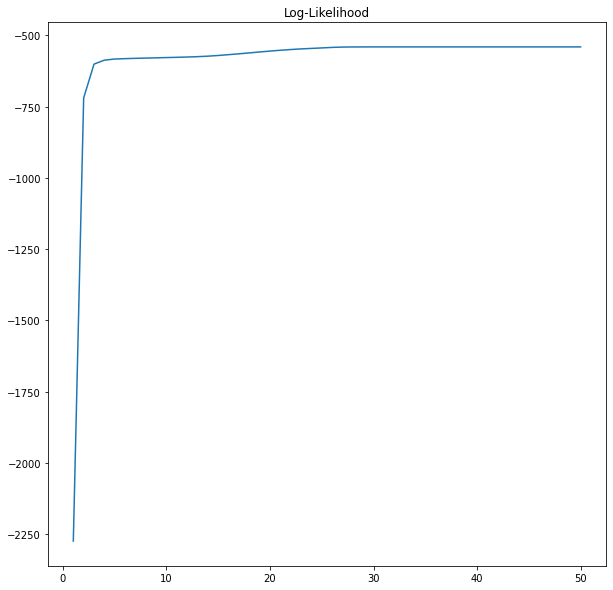

In [13]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

**Visualizzazione dei clusters e dei parametri della GGM**

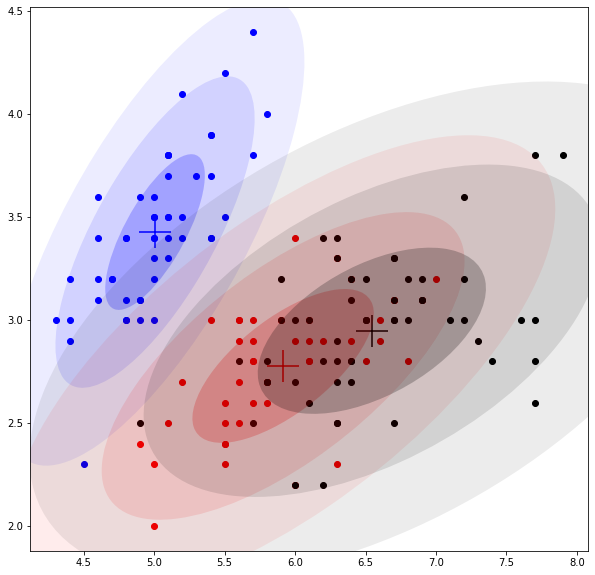

In [14]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order],eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * 
                              cov_factor * 2,
                              height=np.sqrt(eigenvalues[1]) * cov_factor * 2, 
                              angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 /
                                   (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], 
                       s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], 
                       marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

NOTA: aprendo il file __gmm.gif__  è possibile visulizzare un animazione di come la stima dei cluster migliori ad ogni iterazione.

## Implementazione usando scikit-learn ##

quella da usare in pratica ...

In [15]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n',
      np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[5.9170732  2.77804839 4.20540364 1.29848217]
 [5.006      3.428      1.462      0.246     ]
 [6.54639415 2.94946365 5.48364578 1.98726565]]
Means by our implementation:
 [[5.006      3.428      1.462      0.246     ]
 [5.9149696  2.77784365 4.20155324 1.29696686]
 [6.54454866 2.94866115 5.47955346 1.98460497]]
Scores by sklearn:
 [ 1.57050082  0.73787138  1.14436656  0.92913238  1.411028   -0.09451903
  0.05266884  1.62442195  0.27082378  0.16706624  0.83489877  0.77168582
  0.29597841 -1.79224582 -3.41557928 -2.10529279 -1.12995447  1.47503579
 -0.84612536  0.97699215]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]


## Esercizi: ##

* provare a cambiare il numero di cluster nella GMM da 1 a 10 ... la logLikelihood fornisce informazioni sul valore giusto del numeori di cluster (3)? 

* inizializzando la GMM con centroidi random invece che con i valori ottenuti da k-means si ottengono prestazioni altrettando buone?

* come si ottengono predizione di classe e probabilità di classe per la GMM in scikit-learn? Dividete il campione in 80% trainign e 20% test, addestrate la GMM con il training set e predicete label di classe e probabilità di classe per gli eventi di test ... quale è l'accuracy ottenuta? 

## Esercizi svolti 
### la ricerca del numero di cluster giusto
Si compie un ciclo dei numeri di cluster da 1 a 10 e si cerca di capire quale sia il valore ottimale<br>
Per farlo si analizza preliminarmente l'andamento della likelihood per capire se questa è portatrice di informazioni.<br>
In un solo plot è riprodotta la likelihood in funzione delle epoche variando il numero dei centri. Si osserva che escludendo il caso con 1 centroide, che è banale, aumentando la taglia del cluster si impiegano più epoche per giungere a saturazione e il tempo per arrivare è proporzionale alla taglia. <br>

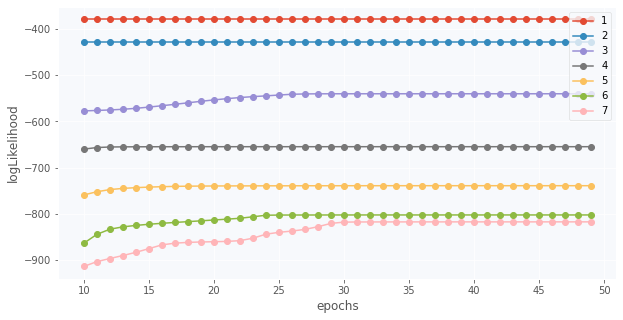

In [74]:
import warnings
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='#f7f9fc'
warnings.filterwarnings("ignore")
plt.close()
n_epochs=50
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
# ci si deve fermare a 8
for n_clusters in range(1, 8):
  clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(
      X, n_clusters, n_epochs)
  ax.plot(range(10, n_epochs), likelihoods[10:], '-o', label=str(n_clusters))
ax.set(xlabel='epochs', ylabel='logLikelihood')
ax.legend()
plt.show()

In [0]:
# fittiamo con sklearn con il numero di cluster da 3 a 8
# e inseriamo i risultati in una lista
gmms=[]
for n_clusters in range(2, 8):
  gmms.append(
      GaussianMixture(n_components=n_clusters, max_iter=n_epochs).fit(X)
  )

Osserviamo il potere predittivo dell'algoritmo al variare del numero di clusters. Scegliamo di adottare come features per visualizzare i dati la seconda e la quarta. <br>
In questo caso si osserva che la miglior divisione avviene con 2 classi e che i dati clusterizzano in maniera naturale in 2 classi, differentemente dalle 3 previste, nonostante anche il risultato con 3 classi sia accettabile. <br>
A conferma di tale teoria si procede anche calcolando per i vari modelli il *Bayesian Information Criterion* (BIC), che va minimizzato.<br>
Anche questo criterio ha identificato l'uso di 2 cluster come ottimale.<br>
Si può concludere pertanto che procedendo in maniera non supervisionata l'algoritmo identifica solo 2 classi, imputabile al fatto che 2 delle 3 sono molto simili tra di loro.

In [0]:
# Funzione per plottare la divisione fatta dall'algoritmo
def plot_class(prediction, ax):
  for i in range(np.amax(prediction).astype(int)+1):
    data = X[prediction==i]
    ax.plot(data[:,1], data[:,3], '.')

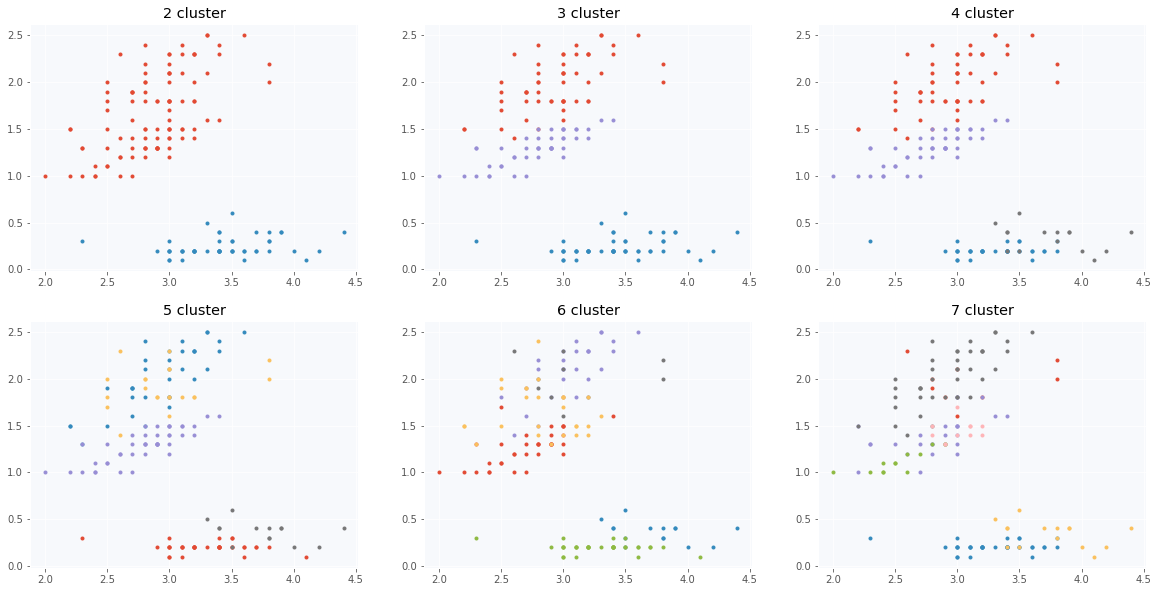

In [75]:
plt.close()
fig, ax_mat = plt.subplots(2, 3, figsize=(20,10))
axs = np.ravel(ax_mat)
for i, gmm in enumerate(gmms):
  plot_class(gmm.predict(X), ax=axs[i])
  axs[i].set(title=f"{gmm.n_components} cluster")

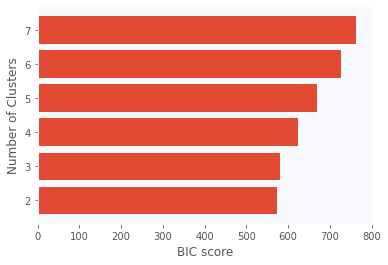

In [76]:
plt.barh(
    [gmm.n_components for gmm in gmms], 
    [gmm.bic(X) for gmm in gmms])
plt.xlabel("BIC score")
plt.ylabel("Number of Clusters")
plt.show()

### Inizializzazione random dei centroidi
Implementiamo il metodo ` Gaussian Mixture` scegliendo i centroidi in maniera random e osserviamo la differenza rispetto a quello con `k-means`.<br>


In [0]:
gmmr = GaussianMixture(
    n_components=3, max_iter=50,
    init_params='random',
).fit(X)
gmmk = GaussianMixture(
    n_components=3, max_iter=50,
    init_params='kmeans',
).fit(X)

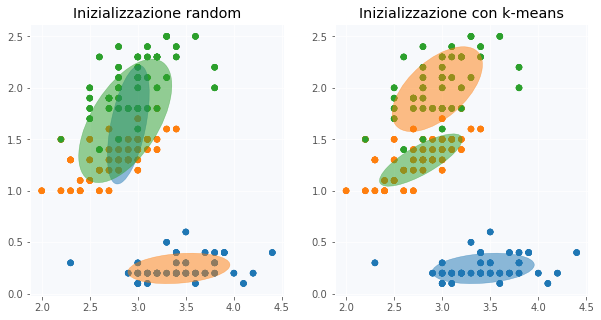

In [119]:
#from sklearn documentation
import itertools
from matplotlib import cm, patches
plt.close()
# plotta i samples, colorati secondo le labels 
# con le regioni di confidenza in 2 sigma delle gaussiane
def plot_results(ax, x, y, labels, means, covariances, title=""):
    color_iter = itertools.cycle(cm.get_cmap('tab10').colors)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.

        ax.scatter(x, y, c=labels, cmap='tab10', 
            vmin=0, vmax=10,
        )
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set(title=title)

means = gmmr.means_[:, [1, 3]]
cov = gmmr.covariances_[:, [1, 3]][..., [1, 3]]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_results(axs[0], X[:, 1], X[:, 3], iris.target, means, cov, title="Inizializzazione random")
means = gmmk.means_[:, [1, 3]]
cov = gmmk.covariances_[:, [1, 3]][..., [1, 3]]
plot_results(axs[1], X[:, 1], X[:, 3], iris.target, means, cov, title="Inizializzazione con k-means")
plt.show()

Come si vede dalla figura, l'inizializzazione a k-means è di gran lunga preferibile.

### Training e applicazione 
Dividiamo il campione di modo che una parte, 80%, sia impegato come training set mentre il restante come test quindi su questo viene calcolata la probabilità di appartenenza e la predizione. <br>
Viene addestrato il modello imponendo come numero di clusters 3. <br>
In questo modo si ha un'accuracy di circa il 90%.<br>
<br>
Un'altro modo per valutare le prestazioni è l'uso di metriche invarianti per permutazioni di indici (https://scikit-learn.org/dev/modules/clustering.html#clustering-performance-evaluation).
Le metriche adottate sono AMI, ARI e il metodo di Fowlkes-Mallows

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve as plroc
from sklearn.metrics import accuracy_score as acc
Y = iris.target
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, Y, test_size=0.2, shuffle=True,
)

In [0]:
# Effettuiamo il fit
n_cluster = 3
gmm_us = GaussianMixture(n_components=3,max_iter=50).fit(Xtrain)

Associamo ad ogni cluster una label, basandoci sulla label più frequente in ogni cluster.

In [141]:
import scipy.stats
cluster_pred_train = gmm_us.predict(Xtrain)

# lista che associerà indici di cluster e indici di classe
cluster_to_target = [] 

mode = lambda arr: scipy.stats.mode(arr).mode[0]
for i in range(n_cluster):
    where = (cluster_pred_train == i)
    curr_cluster_target = Ytrain[where] # targets dei punti nel cluster i-esimo
    target = int(mode(curr_cluster_target))
    cluster_to_target.append(target)
    print(f"Cluster: {i}, target: {target}")
# dato l'indice di cluster C corrispondente alla classe T, 
# cluster_to_labels[C] = T

Cluster: 0, target: 1
Cluster: 1, target: 0
Cluster: 2, target: 2


In [147]:
get_target = np.vectorize(lambda c: cluster_to_target[c])
def cluster_acc(pred_cluster, true_target):
  pred_target = get_target(pred_cluster)
  return acc(true_target, pred_target)

train_acc = cluster_acc(cluster_pred_train, Ytrain)
print(f"Train accuracy: {train_acc}")
test_acc = cluster_acc(gmm_us.predict(Xtest), Ytest)
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9
Test accuracy: 0.9333333333333333


In [148]:
## metriche invarianti per permutazioni di indici
from sklearn import metrics

pred_test = gmm_us.predict(Xtest)
methods={'AMI':metrics.adjusted_mutual_info_score,
         'ARI':metrics.adjusted_rand_score,
         'Fowlkes':metrics.fowlkes_mallows_score}
for name,method in methods.items():
  print(name, method(Ytest, pred_test))

AMI 0.8139275173420313
ARI 0.7857595159361148
Fowlkes 0.8595444949604056
